In [1]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sprawl.storage import get_osm_data, get_stored_cities
from sprawl.dispersion import _apply_polygon_closest_distance_neighbor

import matplotlib.pyplot as plt

# Evaluate approximations
   * Closest neighbor distance computation for each building
   * Land use inference for uncertain buildings given polygons with defined land use

## Closest neighbor distance 
* Retrieve the processed OpenStreetMap data

In [2]:
# Test on a given city
city_ref = get_stored_cities()[0]
print( city_ref )

Zagreb_Croatia


In [3]:
# Retrieve data
df_osm = get_osm_data( city_ref )

# Drop columns, keep geometries
columns_drop = [ col for col in df_osm.columns if col not in ['geometry'] ]
df_osm.drop(columns_drop,inplace=True,axis=1)

from shapely.geometry import Point
# Drop rows, keep polygons (buildings)
geometries = df_osm['geometry'].map( lambda x: type(x) == Point )
df_osm.drop( df_osm[geometries].index, inplace=True )

* Calculate the closest neighboring distance with different approximation values

In [4]:
import time

# Test K neighboring values
K_nearest_values = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
time_values = []

for K_nearest in K_nearest_values: # For each K neighbors value, calculate the closest distances
    print ( "K neighbors:",K_nearest )
    
    start = time.time()
    
    _apply_polygon_closest_distance_neighbor(df_osm, K_nearest = K_nearest)
    df_osm['closest_d']
    df_osm.rename(columns={'closest_d': 'K_'+str(K_nearest)}, inplace=True)
    
    end = time.time()
    time_values.append( end-start )
    
    print ( "Time:",str(end-start) )

K neighbors: 20
Time: 91.25518894195557
K neighbors: 40
Time: 161.61907291412354
K neighbors: 60
Time: 231.69448232650757
K neighbors: 80
Time: 302.65931844711304
K neighbors: 100
Time: 374.8525826931
K neighbors: 120
Time: 438.05286955833435
K neighbors: 140
Time: 508.8374490737915
K neighbors: 160
Time: 577.8181850910187
K neighbors: 180
Time: 634.7658643722534
K neighbors: 200
Time: 681.8726420402527


* Verify difference by comparing against the best approximation made

In [5]:
# Best approximation:
MAX_K = max(K_nearest_values)
print ( "Maximum K_nearest (best approximated value):",MAX_K )
print ()

diff_mean = []
diff_sum = []
distance_mean = []
for K_nearest in K_nearest_values:
    print ( "K_nearest:",K_nearest )
    
    print ( "Mean closest distance calculated:", df_osm['K_'+str(K_nearest)].mean() )
    distance_mean.append( df_osm['K_'+str(K_nearest)].mean() )
    
    if (K_nearest == MAX_K): continue
    
    # Compute difference between approximated and 'most' approximated real value
    diff = df_osm['K_'+str(K_nearest)].subtract(df_osm['K_'+str(MAX_K)]).abs()
    
    diff_mean.append( diff.mean() )
    diff_sum.append( diff.sum(axis=0) )
    
    print ( "Sum of differences (compared to best approximated value):",diff.sum(axis=0) )
    print ( "Number of differing rows (compared to best approximated value):",len(diff[diff != 0 ]) )
    print ( "Mean difference encountered (compared to best approximated value):", diff.mean() )
    print ()

Maximum K_nearest (best approximated value): 200

K_nearest: 20
Mean closest distance calculated: 5.461420863307704
Sum of differences (compared to best approximated value): 593.9413317380911
Number of differing rows (compared to best approximated value): 62
Mean difference encountered (compared to best approximated value): 0.01536121380416633

K_nearest: 40
Mean closest distance calculated: 5.4546539454212875
Sum of differences (compared to best approximated value): 332.2984516597659
Number of differing rows (compared to best approximated value): 20
Mean difference encountered (compared to best approximated value): 0.008594295917749021

K_nearest: 60
Mean closest distance calculated: 5.452642046354884
Sum of differences (compared to best approximated value): 254.5083742573038
Number of differing rows (compared to best approximated value): 9
Mean difference encountered (compared to best approximated value): 0.006582396851346277

K_nearest: 80
Mean closest distance calculated: 5.4464866

* Plot the mean of the computed closest distances for each approximation

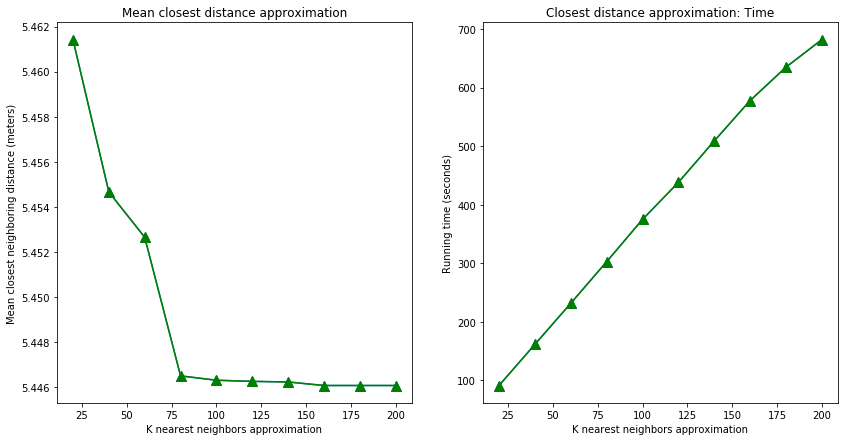

In [6]:
# Plots
fig, axes = plt.subplots(1,2, figsize=(14,7))
marker, marker_size = '^', 10

### Approximation
ax = axes[0]
ax.set_xlabel("K nearest neighbors approximation")
ax.set_ylabel("Mean closest neighboring distance (meters)")
ax.set_title("Mean closest distance approximation")

ax.plot( K_nearest_values, distance_mean, K_nearest_values, distance_mean, 'g', marker=marker, markersize=marker_size)

### Time
ax = axes[1]
ax.set_xlabel("K nearest neighbors approximation")
ax.set_ylabel("Running time (seconds)")
ax.set_title("Closest distance approximation: Time")

ax.plot( K_nearest_values, time_values, K_nearest_values, time_values, 'g', marker=marker, markersize=marker_size)

plt.show()

## Land use inference

In [7]:
from sprawl.core import get_input_shapefiles
from sprawl.osm_shapefile_parse import process_shapefiles

city_refs, poly_shapefiles, point_shapefiles = get_input_shapefiles()
polygon_shapefile, point_shapefile = poly_shapefiles[0], point_shapefiles[0]

* Perform land usage inference using different approximation values

In [8]:
# Test K neighboring values
K_nearest_values = [ 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]
time_values = []
inferred_residential_values = []
inferred_activities_values = []

for K_nearest in K_nearest_values: # For each K neighbors value, calculate the closest distances
    print ( "K neighbors:",K_nearest )
    
    start = time.time()
    
    df_osm_processed, bbox = process_shapefiles(polygon_shapefile, point_shapefile, K_nearest = K_nearest)
    
    print ( "Total number for each land usage:",df_osm_processed.classification.value_counts() )

    df_osm_processed['inferred'] = df_osm_processed.key_value.apply(lambda x: 'inferred' in x.keys() )
    print ( "Number of inferred land usages:",len(df_osm_processed[ df_osm_processed['inferred'] ]) )
    
    inferred_value_counts = df_osm_processed[ df_osm_processed['inferred'] ].classification.value_counts()
    print ( "Number of inferred land usages per classification:" )
    print ( "Number of residential inferred land usages:",inferred_value_counts.residential )
    print ( "Number of activities inferred land usages:",inferred_value_counts.activity )
    
    inferred_residential_values.append( inferred_value_counts.residential )
    inferred_activities_values.append( inferred_value_counts.activity )
    
    end = time.time()
    time_values.append( end-start )
    
    print ( "Time (seconds):",str(end-start) )
    print ()

K neighbors: 10
Total number for each land usage: residential    35716
activity        7776
mixed              2
Name: classification, dtype: int64
Number of inferred land usages: 35148
Number of inferred land usages per classification:
Number of residential inferred land usages: 34077
Number of activities inferred land usages: 1071
Time (seconds): 140.0178153514862

K neighbors: 20
Total number for each land usage: residential    35696
activity        7786
mixed              2
Name: classification, dtype: int64
Number of inferred land usages: 35138
Number of inferred land usages per classification:
Number of residential inferred land usages: 34057
Number of activities inferred land usages: 1081
Time (seconds): 152.96601152420044

K neighbors: 30
Total number for each land usage: residential    35683
activity        7791
mixed              2
Name: classification, dtype: int64
Number of inferred land usages: 35130
Number of inferred land usages per classification:
Number of residential 

* Plot the different land usages inferences made

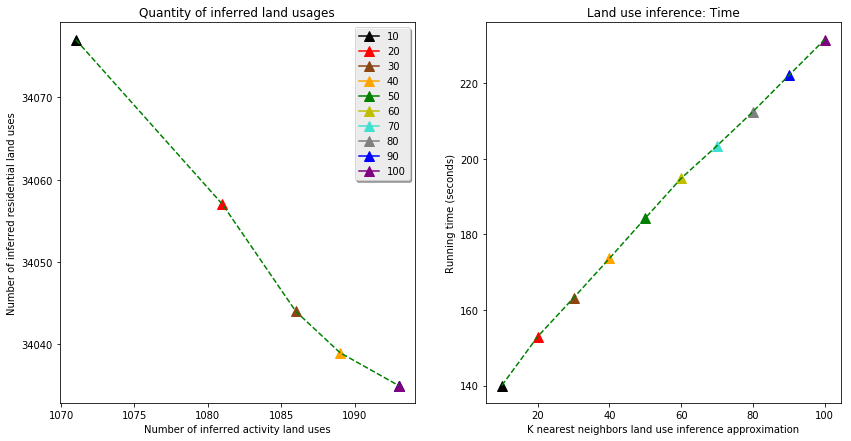

In [9]:
# Plots
fig, axes = plt.subplots(1,2, figsize=(14,7))
import itertools
# Default colors
colors = ['black','red','saddlebrown','orange','green','y','turquoise','gray','blue','purple','magenta']
marker, marker_size = '^', 10

####### Approximation
ax = axes[0]
ax.set_ylabel("Number of inferred residential land uses")
ax.set_xlabel("Number of inferred activity land uses")
ax.set_title("Quantity of inferred land usages")

color = itertools.cycle(colors)

for activities, residential, K_ in zip(inferred_activities_values[:-1], inferred_residential_values[:-1], K_nearest_values[:-1]):
    ax.plot( activities, residential, color=next(color), marker=marker, markersize=marker_size, label=str(K_) )
# Plot last one with different color
ax.plot( inferred_activities_values[-1], inferred_residential_values[-1], color=next(color), marker=marker, markersize=marker_size, label=str( K_nearest_values[-1] ) )

# Legend
ax.legend(loc='upper right', shadow=True)

# Draw lines
ax.plot( inferred_activities_values, inferred_residential_values, 'g--' )
    
####### Time
ax = axes[1]
ax.set_xlabel("K nearest neighbors land use inference approximation")
ax.set_ylabel("Running time (seconds)")
ax.set_title("Land use inference: Time")

color = itertools.cycle(colors)

for K_, time in zip(K_nearest_values[:-1], time_values[:-1]):
    jet = plt.cm.jet
    ax.plot( K_, time, label=str(K_), color=next(color), marker=marker, markersize=marker_size )
# Plot last one with different color
ax.plot( K_nearest_values[-1], time_values[-1], color=next(color), marker=marker, markersize=marker_size )

# Draw lines
ax.plot( K_nearest_values, time_values, 'g--' )

plt.show()